In [7]:
import pandas as pd
import pycaret
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pycaret.classification import *
from imblearn.over_sampling import SMOTE

In [8]:
df = pd.read_pickle("../data/depresjon/depresjon_preprocessed.pkl")
df

timestamp  user_id    activity  days  gender  age  afftype  \
0    1052265600000000000        1  174.144444    11       0    0      2.0   
1    1052352000000000000        1  156.247222    11       0    0      2.0   
2    1052438400000000000        1  124.135417    11       0    0      2.0   
3    1052524800000000000        1  134.961806    11       0    0      2.0   
4    1052611200000000000        1   99.439583    11       0    0      2.0   
..                   ...      ...         ...   ...     ...  ...      ...   
400  1086480000000000000        9  162.295833    13       0    1      1.0   
401  1086566400000000000        9  224.508333    13       0    1      1.0   
402  1086652800000000000        9  202.056250    13       0    1      1.0   
403  1086739200000000000        9  168.656250    13       0    1      1.0   
404  1086825600000000000        9  115.589207    13       0    1      1.0   

     melanch  inpatient  edu  ...  month_sin  weekday_sin  week_sin   day_sin  \
0        2.0        2.0    1  ...  -0.974928     0.974928 -0.998027  0.988468   
1        2.0        2.0    1  ...  -0.974928     0.433884 -0.998027  0.998717   
2        2.0        2.0    1  ...  -0.974928    -0.433884 -0.998027  0.968077   
3        2.0        2.0    1  ...  -0.974928    -0.974928 -0.998027  0.897805   
4        2.0        2.0    1  ...  -0.974928    -0.781831 -0.998027  0.790776   
..       ...        ...  ...  ...        ...          ...       ...       ...   
400      2.0        2.0    1  ...  -0.781831    -0.781831 -0.481754  0.937752   
401      2.0        2.0    1  ...  -0.781831     0.000000  -0.24869  0.988468   
402      2.0        2.0    1  ...  -0.781831     0.781831  -0.24869  0.998717   
403      2.0        2.0    1  ...  -0.781831     0.974928  -0.24869  0.968077   
404      2.0        2.0    1  ...  -0.781831     0.433884  -0.24869  0.897805   

     month_cos  weekday_cos  week_cos   day_cos  activity_quantile  \
0    -0.222521    -0.222521  0.062791  0.151428                  1   
1    -0.222521    -0.900969  0.062791 -0.050649                  1   
2    -0.222521    -0.900969  0.062791 -0.250653                  1   
3    -0.222521    -0.222521  0.062791 -0.440394                  1   
4    -0.222521     0.623490  0.062791 -0.612106                  1   
..         ...          ...       ...       ...                ...   
400   0.623490     0.623490  0.876307  0.347305                  1   
401   0.623490     1.000000  0.968583  0.151428                  1   
402   0.623490     0.623490  0.968583 -0.050649                  1   
403   0.623490    -0.222521  0.968583 -0.250653                  1   
404   0.623490    -0.900969  0.968583 -0.440394                  1   

     user_activity_quantile  
0                         1  
1                         1  
2                         1  
3                         1  
4                         0  
..                      ...  
400                       0  
401                       2  
402                       2  
403                       1  
404                       0  

[389 rows x 24 columns]

In [9]:
df['category_madrs'].value_counts()

0    201
1    188
Name: category_madrs, dtype: int64

In [10]:
def train_test_split_per_user(data, train_size=0.7):
    users = list(set(data.user_id))
    users = sorted(users, reverse=True)  # fix randomness
    total_users = len(users)
    slice = int(train_size * total_users)
    users_train = users[:slice]
    users_test = users[slice:]
    return data[data.user_id.isin(users_train)], data[data.user_id.isin(users_test)]

In [11]:
train_data, test_data = train_test_split_per_user(df)

fold_groups = train_data.user_id
train_data = train_data.drop(columns=['user_id'])
test_data = test_data.drop(columns=['user_id'])

In [18]:
#s = setup(data=train_data, target='category_madrs', session_id=123, fold_strategy='groupkfold', fold=5,  fold_groups=fold_groups, test_data=test_data, normalize=True)
s = setup(data=train_data, target='category_madrs', session_id=123, test_data=test_data, normalize=True)

In [19]:
best = compare_models(sort = 'F1')

Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [20]:
print(best)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [21]:
predictions_df = predict_model(best, data=test_data)

In [22]:
from sklearn.metrics import f1_score

f1 = f1_score(predictions_df['category_madrs'], predictions_df['Label'])

print(f'F1 Score: {f1:.4f}')

F1 Score: 0.2560


In [24]:
# Extracting X_test (features) - this includes all columns except the label and prediction columns
X_test = predictions_df.drop(columns=['Label', 'Score'])

# Extracting y_test (true labels)
y_test = predictions_df['category_madrs']  # Adjust this to your actual target column name

# Extracting y_pred (predicted labels)
y_pred = predictions_df['Label']

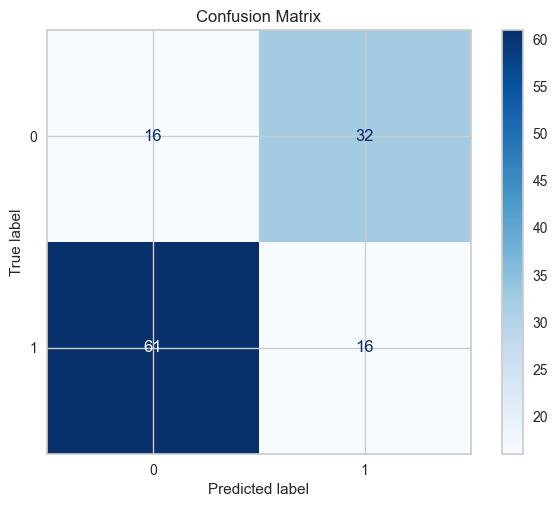

In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [26]:
df.columns

Index(['timestamp', 'user_id', 'activity', 'days', 'gender', 'age', 'afftype',
       'melanch', 'inpatient', 'edu', 'marriage', 'work', 'is_weekend',
       'category_madrs', 'month_sin', 'weekday_sin', 'week_sin', 'day_sin',
       'month_cos', 'weekday_cos', 'week_cos', 'day_cos', 'activity_quantile',
       'user_activity_quantile'],
      dtype='object')

In [27]:
from pycaret.classification import setup, create_model, evaluate_model
from sklearn.model_selection import LeaveOneGroupOut
import pandas as pd

In [28]:
X = df.drop(columns=['category_madrs', 'user_id'])  # Features
y = df['category_madrs']  # Labels
groups = df['user_id']  # Groups for LOPO

# Combine X and y for PyCaret
data = pd.concat([X, y], axis=1)

In [29]:
s = setup(data=train_data, target='category_madrs', session_id=123, test_data=test_data, normalize=True)

In [30]:
best = compare_models(sort = 'F1')

Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [33]:
logo = LeaveOneGroupOut()

model = create_model('lightgbm', fold_strategy=logo, fold=logo.get_n_splits(X, y, groups=groups), groups=groups)

# Step 5: Evaluate the model
evaluate_model(model)

ValueError: groups has length 389 which doesn't match X_train length of 264.

In [38]:


# Import necessary libraries
from pycaret.classification import setup, create_model, finalize_model, predict_model
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score
import pandas as pd

# Assuming you already have a DataFrame `df` with features, labels, and a 'person_id' column
# Replace 'label_column' with your actual label column name, and 'person_id' with the identifier for individuals

# Step 1: Prepare your data
X = df.drop(columns=['category_madrs', 'user_id'])  # Features
y = df['category_madrs']  # Labels
groups = df['user_id']  # Groups for LOPO

# Combine X and y for PyCaret
data = pd.concat([X, y], axis=1)

# Step 2: Initialize PyCaret setup without cross-validation
clf = setup(data=data, target='category_madrs', session_id=123, fold=2)

# Step 3: Initialize Leave-One-Group-Out cross-validation strategy
logo = LeaveOneGroupOut()

# Step 4: Manually perform LOPO cross-validation
f1_scores = []
for train_idx, test_idx in logo.split(X, y, groups):
    # Split the data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Combine X_train and y_train for PyCaret
    train_data = pd.concat([X_train, y_train], axis=1)
    
    # Set up PyCaret with the training data
    clf = setup(data=train_data, target='category_madrs', session_id=123,fold=2)
    
    # Create the model
    model = create_model('lightgbm')
    
    # Finalize the model (fit on the entire training data)
    finalized_model = finalize_model(model)
    
    # Make predictions on the test data
    predictions = predict_model(finalized_model, data=X_test)
    
    # Evaluate the F1 score for this fold
    f1 = f1_score(y_test, predictions['Label'], average='weighted')
    f1_scores.append(f1)
    print(f"Fold F1 Score: {f1}")
    
# Calculate the mean F1 score across all LOPO folds
mean_f1_score = sum(f1_scores) / len(f1_scores)
print(f"Mean LOPO F1 Score: {mean_f1_score}")


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.8085106382978724


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 1.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 1.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.0
     ---------------------------------------- 59.0/59.0 kB 1.0 MB/s eta 0:00:00
   ---------------------------------------- 15.6/15.6 MB 10.2 MB/s eta 0:00:00
   ---------------------------------------- 8.3/8.3 MB 11.5 MB/s eta 0:00:00
Using cached scipy-1.10.1-cp310-cp310-win_amd64.whl (42.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.3
    Uninstalling numpy-1.26.3:
      Successfully uninstalled numpy-1.26.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.12.0
    Uninstalling scipy-1.12.0:
      Successfully uninstalled scipy-1.12.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.0
    Uninstalling scikit-learn-1.4.0:
      Successfully uninstalled scikit-learn-1.4.0


  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerometer 7.1.1 requires joblib==1.1.*, but you have joblib 1.3.2 which is incompatible.
accelerometer 7.1.1 requires 

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.2222222222222222


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 1.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 1.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 0.0


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fold F1 Score: 1.0
Mean LOPO F1 Score: 0.2741242209327316


In [ ]:
y_pred.to_csv('../data/depresjon/predictions/depresjon_pred_generic.csv', index=False)
X_test.to_csv('../data/depresjon/predictions/depresjon_X_test_generic.csv', index=False)
y_test.to_csv('../data/depresjon/predictions/depresjon_y_test_generic.csv', index=False)